In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import math
from sklearn.metrics import r2_score
from re import S
from pandas.core.frame import DataFrame
from scipy.stats import shapiro, cauchy
from mpl_toolkits.mplot3d import Axes3D

In [5]:
#read CSV file
csvdata = pd.read_csv("../Z_Data/CSVread3.csv", sep = ";", decimal=",")


In [6]:
#Set log(DilutionF) as index
logspre = csvdata["log(dil)"].values.tolist()
logspre.remove("min")
logspre.remove("max")
logs = []
for i in logspre:
    k = i.replace(",",".")
    k = float(k)
    logs.append(k)

alldata = csvdata.set_index("log(dil)")
alldata.index.names = [None]

In [7]:
###Make Subsets of data
#generate list of names:
rep = int(len(alldata.columns)/3)
dataNames = []
for i in range(rep):
    naam = "sample_" + str(i+1)
    dataNames.append(naam)

#Add Dataframe to name in dictionary
tel = 0
frames = []
for k in range(rep):
    frame = alldata.iloc[:,[tel, tel+1, tel+2]]
    tel = tel+3
    frames.append(frame)

joined = dict(zip(dataNames, frames))

In [8]:
#IC50 curve, initial
def IC50(logs, dict):
    identity = []
    IC50 = []
    rsq = []
    hill = []
    absE = []
    for names, frame in dict.items():
        identity.append(names)

        mins = frame.loc["min"][0]
        maxs = frame.loc["max"][0]
        dataOnly = frame.drop(["min","max"])

        ###Convert 8x4 dataframe to 24x2
        xvalues = []
        for i in range(len(logs)):
            extra = [logs[i]] * 3
            xvalues.extend(extra)
        lijstdat = dataOnly.stack().tolist()
        lijstdata = [100*(1-(m - mins) / ( maxs - mins )) for m in lijstdat]
        
        ###Limit values to 0-100 range
        #for i in range(len(lijstdata)):
        #    if lijstdata[i]<0:
        #        lijstdata[i] = 0
        #    elif lijstdata[i]>100:
        #        lijstdata[i] = 100

        def logistic_curve(logx, logIC50, Hill):
            return 100 / (1 + 10**((logIC50-np.asarray(logx))*Hill))
            # return ((-100) / (1 + ((np.asarray(logx)/logIC50)**Hill))) + 100
               
        para, cov = curve_fit(logistic_curve, xvalues, lijstdata, maxfev=5000, p0=[3, -1])
        
        ###restrict Hill Slope between 2 values
        #if para[1]>-0.8:
        #    para[1]=-0.8
        #elif para[1]<-1.2:
        #    para[1]=-1.2

        fit1 = logistic_curve(xvalues, para[0], para[1])
        line = np.arange(0, 8, 0.1)
        fit2 = logistic_curve(line, para[0], para[1])
        ###Absolute Error
        #points = np.abs(fit1 - lijstdata)

        ###loop: list of ic50, list of hills, result of fit - real y
        log50s = np.arange(1, 6, 0.01)
        hills = np.arange(-1.6, -0.5, 0.01)
        
        logic50 =[]
        hillslope = []
        absDevi = []
        for l in log50s:
            for h in hills:
                logic50.append(l)
                hillslope.append(h)

                fits = logistic_curve(xvalues, l, h)

                TotalEr = 0
                for o, r in zip(lijstdata, fits):
                    TotalEr += np.abs((o-r))
                absDevi.append(TotalEr)

        #print(len(logic50), len(hillslope), len(absDevi))

        #listss = pd.DataFrame(list(zip(logic50, hillslope, absDevi)), columns = ['LogIC50', "Hill Slope", "absDevi"])
        #print(identity[-1], ": ", listss.iloc[listss["absDevi"].idxmin()])
        
        #print(listss['Hill Slope'].where([listss["absDevi"].idxmin()]))
        nbr = absDevi.index(min(absDevi))
        devi = min(absDevi)
        newhill = hillslope[nbr]
        print("New Hill Slope is %.2f" %newhill, "The new absolute sum of distance is %.2f" %devi)

        ###TestNewValue of Hill
        # new curve    
        def logic(logx, logIC50):
            return 100 / (1 + 10**((logIC50-np.asarray(logx))*newhill))
        para2, cov2 = curve_fit(logic, xvalues, lijstdata, maxfev=5000, p0=[3])
        fitNew1 = logic(xvalues, para2[0])
        fitNew = logic(line, para2[0])
        print("Hill Slope: %.2f"  %newhill, ". IC50: ", int(10**para2[0]), ". r²: ", r2_score(lijstdata, fitNew1), "." )

        ###Results info:
        IC50.append(int(10**para[0]))
        hill.append("%.2f" %para[1])
        score = r2_score(lijstdata, fit1)
        rsq.append("%.2f" %score)

        ###residuals
        points = []
        TotalS = 0
        for o, l in zip(lijstdata, fit1):
            points.append(o-l)
            TotalS += np.abs((o-l))
        absE.append(TotalS)

        ####plot fit curve
        plt.plot(line, fit2)
        plt.plot(line, fitNew, 'k')
        plt.ylim(0, 100)
        plt.xlabel("Log(Dilution Factor)")
        plt.ylabel("% Neutralization")
        plt.xlim(1.5, 5.1)
        # plot datapoints
        plt.scatter(xvalues, lijstdata)

        ###plot errors
        #plt.scatter(xvalues, points)
        #plt.axhline(y=0)
        #plt.xlim(1.5, 5.1)
        #plt.ylabel("Distance between data and curve")
        #plt.xlabel("Log(Dilution Factor)")

        #plt.scatter(para[0], 50, c='red', marker="X")
    results_dict = {"Sample":identity, "IC50":IC50, "HillSlope":hill, "r²": rsq, 'Sum of Absolute Error': absE}
    df_results = pd.DataFrame(results_dict)
    print(df_results)

    #plt.show()


New Hill Slope is -0.59 The new absolute sum of distance is 180.73
Hill Slope: -0.59 . IC50:  7526 . r²:  0.8842130777409045 .
New Hill Slope is -0.97 The new absolute sum of distance is 195.50
Hill Slope: -0.97 . IC50:  2544 . r²:  0.9143914021899743 .
New Hill Slope is -0.76 The new absolute sum of distance is 154.26
Hill Slope: -0.76 . IC50:  6022 . r²:  0.9332784060866324 .
     Sample  IC50 HillSlope    r²  Sum of Absolute Error
0  sample_1  7389     -0.62  0.89             184.050893
1  sample_2  2621     -0.85  0.92             213.484532
2  sample_3  6066     -0.73  0.93             162.385964


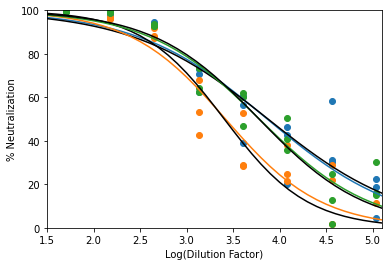

In [9]:
IC50(logs,joined)